In [47]:
import pandas as pd
from pandas.core.frame import DataFrame
import datetime
import time
import re
import networkx as nx
import matplotlib.pyplot as plt
from newspaper import Article

In [372]:
def Newslogs_preprocessing(Newslogs):
    def clean_url(article_url):
        def clean_CHT_url(url):
            if '?chdtv' in url: url = url.replace('?chdtv', '')
            if '?ctrack' in url: url = url[:url.find('?ctrack')]
            return url
        def clean_LBT_url(url):
            if '?utm_source' in url: url = url[:url.find('?utm_source')]
            return url
        if 'chinatimes.com/' in article_url: return clean_CHT_url(article_url)
        if 'ltn.com.tw/' in article_url: return clean_LBT_url(article_url)
    
    Newslogs = [[clean_url(k[0]), k[1], k[2], k[3]] for k in Newslogs]
    Newslogs.reverse()
    return Newslogs

In [373]:
Newslogs = pd.read_csv('/Users/gtingyou/Desktop/firefox_history.csv', encoding='utf8', header=0).values.tolist()
Newslogs = Newslogs_preprocessing(Newslogs)
TODAY_DATE = time.strftime('%Y-%m-%d',datetime.datetime.timetuple(datetime.datetime.now()))
USERINDEX = 'user1'

In [381]:
def create_user_network_nodes(Newslogs, USERINDEX, TODAY_DATE):
    def check_parse_news_details_or_not(article_url) -> bool:
        """Check whether the url is linked to a news or not.
           It returns a bool ->
               True: If the url linked to a news.
               False: If the url doesnt linked to a news, such as a frontpage.
        """
        if 'ltn.com.tw/' in article_url:
            if re.match('https://([a-z]*?).ltn.com.tw/(.*?)/(\d{7})', article_url)!=None:
                return True
            else:
                print('***PAGE NOT NEED DETAILS***\n', article_url)
                return False
        elif 'chinatimes.com/' in article_url:
            def clean_CHT_url(url):
                if '?chdtv' in url: url = url.replace('?chdtv', '')
                if '?ctrack' in url: url = url[:url.find('?ctrack')]
                return url
            article_url = clean_CHT_url(article_url)
            if re.match('https://www.chinatimes.com/(.*?)/(\d{14}-\d{6})', article_url)!=None:
                return True
            else:
                print('***PAGE NOT NEED DETAILS***\n', article_url)
                return False
            
    def get_news_details(article_url, NEWSINDEX, TODAY_DATE):
        """Parse News details, including NewsUrl, PublishDate, NewsTitle and NewsContent.
           It returns
               a list -> news_details: [NewsIndex, ParseDate, NewsUrl, PublishDate, NewsTitle, NewsContent]
               and an int -> NEWSINDEX: Records the NewsIndex
        """
        if check_parse_news_details_or_not(article_url)==True:
            article = Article(article_url)
            try:
                print('***DOWNLOADING***\n', article_url)
                article.download()
                article.parse()
            except:
                print('***FAILED TO DOWNLOAD***\n', article_url)
                return False
            article_date = str(article.publish_date)[:10]

            NEWSINDEX+=1
            news_details = [USERINDEX+'_'+str(NEWSINDEX), TODAY_DATE, article_url, article_date, article.title, article.text]
            return news_details, NEWSINDEX

        elif check_parse_news_detail_or_not(article_url)==False:
            news_details = [article_url, TODAY_DATE, article_url, '', '', '']
            return news_details, NEWSINDEX
        
        
    NEWSINDEX = 0
    user_network_nodes = []
    ### 抓出瀏覽紀錄中不重複的 url
    Newslogs_unique_urls = []
    for log in Newslogs:
        if log[0] not in Newslogs_unique_urls:
            Newslogs_unique_urls.append(log[0])
    ### 針對不重複的 url，爬詳細新聞資料
    for article_url in Newslogs_unique_urls:
        news_details, NEWSINDEX = get_news_details(article_url, NEWSINDEX, TODAY_DATE)
        user_network_nodes.append(news_details)
    return user_network_nodes

In [382]:
def create_user_network_edges(Newslogs, user_network_nodes):
    user_network_edges = []
    for i in range(0, len(Newslogs)-1):
        url_1 = Newslogs[i][0]
        url_2 = Newslogs[i+1][0]
#         print('-'*50+'\n%s\n%s' %(url_1, url_2))
        user_network_nodes_urls = [k[2] for k in user_network_nodes]
        if url_1 in user_network_nodes_urls and url_2 in user_network_nodes_urls:
            c1 = user_network_nodes[user_network_nodes_urls.index(url_1)][0]
            c2 = user_network_nodes[user_network_nodes_urls.index(url_2)][0]
            
            ### 取比較大的時間作為瀏覽時間
            d1 = datetime.datetime.strptime(Newslogs[i][2], "%Y-%m-%d %H:%M:%S")
            d2 = datetime.datetime.strptime(Newslogs[i+1][2], "%Y-%m-%d %H:%M:%S")
            if d1>=d2: parse_date=Newslogs[i][2]
            else: parse_date=Newslogs[i+1][2]
            
            user_network_edges.append([c1, c2, parse_date])
#             print(c1, c2)
    return user_network_edges

In [383]:
user_network_nodes = create_user_network_nodes(Newslogs, USERINDEX, TODAY_DATE)

***PAGE NOT NEED DETAILS***
 https://www.chinatimes.com/
***PAGE NOT NEED DETAILS***
 https://www.chinatimes.com/
***DOWNLOADING***
 https://www.chinatimes.com/realtimenews/20200622001567-260405
***DOWNLOADING***
 https://www.chinatimes.com/realtimenews/20200622002688-260405
***PAGE NOT NEED DETAILS***
 https://news.ltn.com.tw/list/breakingnews
***PAGE NOT NEED DETAILS***
 https://news.ltn.com.tw/list/breakingnews
***PAGE NOT NEED DETAILS***
 https://sports.ltn.com.tw/
***PAGE NOT NEED DETAILS***
 https://sports.ltn.com.tw/
***DOWNLOADING***
 https://sports.ltn.com.tw/news/paper/1381483
***DOWNLOADING***
 https://sports.ltn.com.tw/news/paper/1381484
***DOWNLOADING***
 https://www.chinatimes.com/realtimenews/20200624003302-260409
***DOWNLOADING***
 https://www.chinatimes.com/realtimenews/20200624002599-260409
***DOWNLOADING***
 https://www.chinatimes.com/realtimenews/20200624000070-260409
***PAGE NOT NEED DETAILS***
 https://www.chinatimes.com/realtimenews/
***PAGE NOT NEED DETAILS***
 

In [384]:
user_network_edges = create_user_network_edges(Newslogs, user_network_nodes)

In [385]:
user_network_nodes

[['https://www.chinatimes.com/',
  '2020-06-24',
  'https://www.chinatimes.com/',
  '',
  '',
  ''],
 ['user1_1',
  '2020-06-24',
  'https://www.chinatimes.com/realtimenews/20200622001567-260405',
  '2020-06-22',
  '屈臣氏今、明開賣「櫻花粉」等5色中衛口罩 各大通路一次看 - 生活',
  '端午連假即將到來，消費者依然關心哪裡可以搶口罩，量販超市在端午前夕紛紛推出加碼促銷，今明（ 22、23 ）兩天屈臣氏將開賣特殊色中衛口罩。家樂福21日已開賣第3波口罩，還有滿額折扣及熱門商品買一送一。\n\n●屈臣氏：\n\n屈臣氏網路商店今明兩天早上將開賣網路限定的中衛盒裝醫療口罩，顏色除了熱門的酷黑、深丹寧色外，還新增了青蘋綠、櫻花粉與軍綠等特殊新色，兩天共計販售 3510 盒。\n\n●康是美：\n\n康是美開賣 MIT 台灣製造的「恒大醫用口罩」，單盒 50 片裝，售價 299 元，每人限購 1 盒，預計將於 6 月 26 及 7 月 3 日兩天各陸續上架 200 萬片。\n\n●蝦皮購物：\n\n蝦皮購物每天下午 5 點在蝦皮超市限量開賣 MIT 醫療口罩，單盒 50 片入，不挑色，售價399元，每人每天限購 1 盒。\n\n●Yahoo奇摩購物中心：\n\n每天中午 11 點至 12 點不定時開賣成人醫療口罩，品牌包含：中衛、MOTEX 摩戴舒、匠心等，每人限購 1 盒，售價依網站公告。\n\n●家樂福\n\n第3波MIT口罩6月21日已開賣，172,500片「順易利醫用口罩」 成人款，50入（盒）299元，總計有3450盒將分配到家樂福全台68家量販店販售(每人限買1盒)。\n\n(中時電子報)'],
 ['user1_2',
  '2020-06-24',
  'https://www.chinatimes.com/realtimenews/20200622002688-260405',
  '2020-06-22',
  '好市多中衛口罩又秒殺！民眾哭：一直按一直按 - 生活',
  '櫻花粉、青蘋綠等「中衛醫療彩色口罩」超搶手，除了屈臣氏之外，好

In [386]:
user_network_edges

[['https://www.chinatimes.com/', 'user1_1', '2020-06-23 00:22:33'],
 ['user1_1', 'user1_2', '2020-06-23 00:22:40'],
 ['user1_2',
  'https://news.ltn.com.tw/list/breakingnews',
  '2020-06-23 00:22:51'],
 ['https://news.ltn.com.tw/list/breakingnews',
  'https://sports.ltn.com.tw/',
  '2020-06-23 00:23:02'],
 ['https://sports.ltn.com.tw/',
  'https://news.ltn.com.tw/list/breakingnews',
  '2020-06-23 00:23:12'],
 ['https://news.ltn.com.tw/list/breakingnews',
  'https://sports.ltn.com.tw/',
  '2020-06-23 00:24:06'],
 ['https://sports.ltn.com.tw/', 'user1_3', '2020-06-23 00:25:47'],
 ['user1_3', 'user1_4', '2020-06-23 00:25:57'],
 ['user1_4', 'https://www.chinatimes.com/', '2020-06-24 14:46:35'],
 ['https://www.chinatimes.com/', 'user1_5', '2020-06-24 14:46:41'],
 ['user1_5', 'user1_6', '2020-06-24 14:46:51'],
 ['user1_6', 'user1_7', '2020-06-24 14:46:53'],
 ['user1_7',
  'https://www.chinatimes.com/realtimenews/',
  '2020-06-24 14:47:04'],
 ['https://www.chinatimes.com/realtimenews/',
  'ht

In [387]:
def draw_network(nodes, edges, TODAY_DATE):
    G = nx.Graph() 
    G.add_nodes_from(nodes) 
    G.add_edges_from(edges)
    nx.draw(G,
            pos = nx.spring_layout(G),
            node_color = 'blue',
            edge_color = 'black',
            with_labels = True,
            font_size =5,
            node_size =40)
    plt.savefig('./Networks_png/Network_%s.png' %(TODAY_DATE), dpi=300)
#     plt.show()

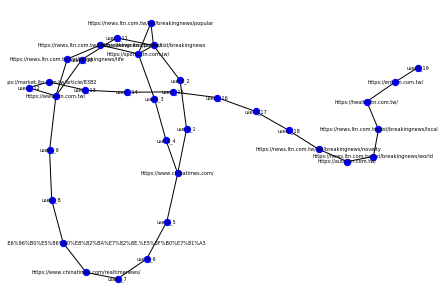

In [388]:
draw_network(nodes=[k[0] for k in user_network_nodes], edges=[[k[0], k[1]] for k in user_network_edges], TODAY_DATE=TODAY_DATE)

In [389]:
import utils_db

In [390]:
utils_db.insert_nodes_table('./user2.db', user_network_nodes)
utils_db.insert_edges_table('./user2.db', user_network_edges)